In [67]:
# notebooks/01_stock_forecasting.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 5)


In [68]:
def adf_test(series, title=""):
    print(f"ADF Test on {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print("\n")


Loading Apple's Data

In [69]:
ticker = "AAPL"           # apple inc
start_date = "2015-01-01" # enough history
end_date = None         

data = yf.download(ticker, start=start_date, end=end_date)
print(data.shape)
data.head()


/var/folders/yc/w2m3f7z1461536r53018g_rr0000gn/T/ipykernel_6784/3093545102.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

(2741, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237555,24.705324,23.798604,24.694239,212818400
2015-01-05,23.554743,24.086803,23.368523,24.006994,257142000
2015-01-06,23.556959,23.816338,23.195601,23.619033,263188400
2015-01-07,23.887274,23.987034,23.654497,23.765343,160423600
2015-01-08,24.805079,24.862719,24.097882,24.215380,237458000


Making it a Time Series

In [70]:
ts = data[['Close']].copy()
ts.rename(columns={'Close': 'y'}, inplace=True)

ts.head()


Price,y
Ticker,AAPL
Date,
2015-01-02,24.237555
2015-01-05,23.554743
2015-01-06,23.556959
2015-01-07,23.887274
2015-01-08,24.805079


Basic Exploration

In [71]:
print(ts.info())
print("Missing Values: \n", ts.isna().sum())
print("Basic Stats: \n", ts.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2741 entries, 2015-01-02 to 2025-11-24
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   (y, AAPL)  2741 non-null   float64
dtypes: float64(1)
memory usage: 42.8 KB
None
Missing Values: 
 Price  Ticker
y      AAPL      0
dtype: int64
Basic Stats: 
 Price             y
Ticker         AAPL
count   2741.000000
mean     104.772674
std       72.851219
min       20.604076
25%       36.498737
50%       83.419876
75%      167.623688
max      275.920013


Plotting the Time Series

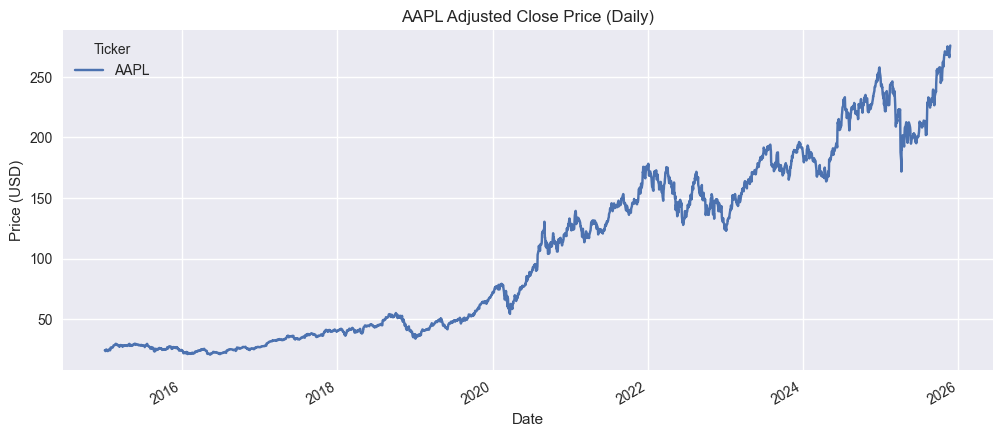

In [72]:
ts['y'].plot(title=f"{ticker} Adjusted Close Price (Daily)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


From the graph, it is visible that the series is not stationary with a clear trend and changing variance.

Also for ARIMA and Decomposition, it’s cleaner to work at monthly level (we take the value at last day of each month instead of daily)

/var/folders/yc/w2m3f7z1461536r53018g_rr0000gn/T/ipykernel_6784/150408382.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_m = ts.resample('M').last()  # last trading day of each month


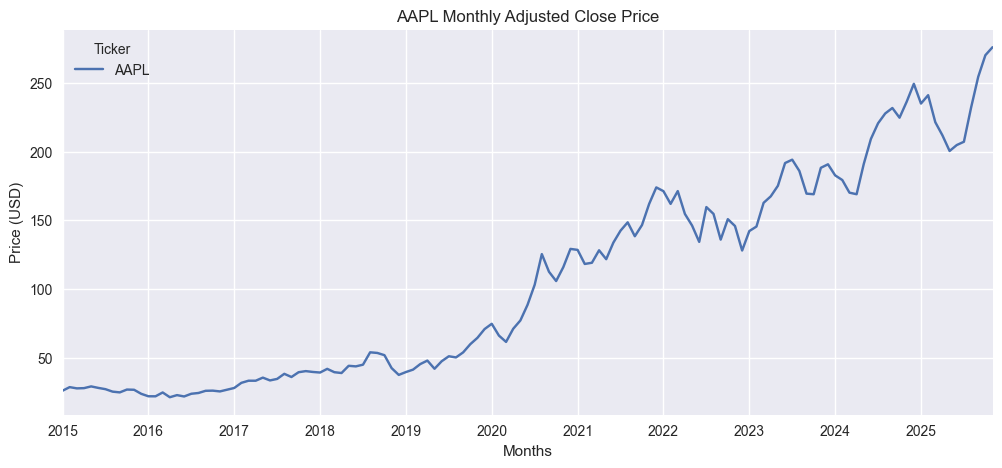

In [73]:
ts_m = ts.resample('M').last()  # last trading day of each month
ts_m['y'].plot(title=f"{ticker} Monthly Adjusted Close Price")
plt.xlabel("Months")
plt.ylabel("Price (USD)")
plt.show()


In [74]:
series = ts_m.copy() 
series.head()


Price,y
Ticker,AAPL
Date,
2015-01-31,25.973394
2015-02-28,28.590902
2015-03-31,27.693958
2015-04-30,27.854210
2015-05-31,29.117092


saving this processed time series to Data/

In [75]:
os.makedirs("../data/raw", exist_ok=True)

series.to_csv("../data/raw/aapl_monthly.csv")

DECOMPOSITION (Trend + Seasonability + Residuals)

In [76]:
result = seasonal_decompose(series['y'], model= 'Additive', period=12)

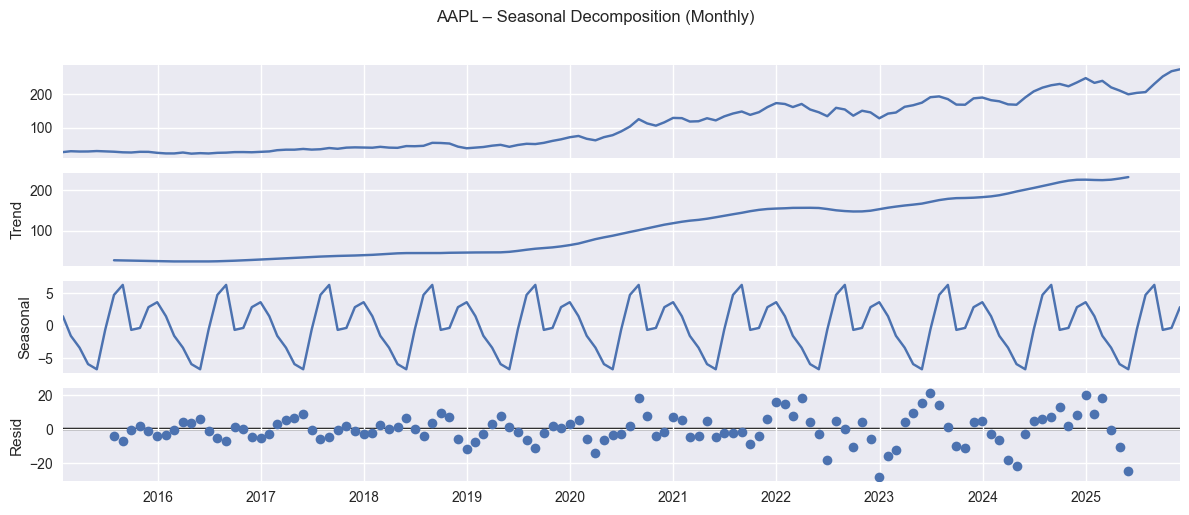

In [77]:
fig = result.plot()
fig.suptitle(f"{ticker} – Seasonal Decomposition (Monthly)", y=1.02)
plt.tight_layout()
plt.show()

Stock prices usually do not show meaningful seasonality. The decomposition attempt produces a mathematically forced sinusoidal pattern that does not reflect real behaviour.
Instead, we use differencing/log-returns and rely on ARIMA, SARIMA, Prophet, and anomaly detection techniques which are more suitable for financial time series.

In [78]:
adf_test(series['y'], title="Original Series (Monthly)")


ADF Test on Original Series (Monthly)
ADF Statistic             1.696406
p-value                   0.998120
# Lags Used              10.000000
# Observations Used     120.000000
Critical Value (1%)      -3.486056
Critical Value (5%)      -2.885943
Critical Value (10%)     -2.579785
dtype: float64




As p-value way greater than 0.005 and there is a clear trend, for that we will start with the first differencing.

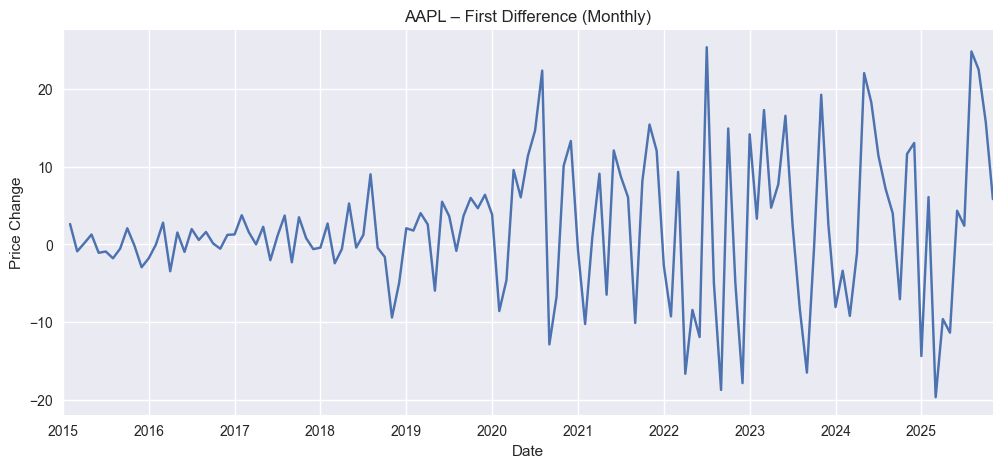

In [79]:
series['y_diff1'] = series['y'].diff()

series['y_diff1'].plot(title=f"{ticker} – First Difference (Monthly)")
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.show()

In [80]:
adf_test(series['y_diff1'], title="First Difference")

ADF Test on First Difference
ADF Statistic          -9.550649e+00
p-value                 2.577388e-16
# Lags Used             0.000000e+00
# Observations Used     1.290000e+02
Critical Value (1%)    -3.482088e+00
Critical Value (5%)    -2.884219e+00
Critical Value (10%)   -2.578864e+00
dtype: float64




As the trend problem is removed, seasonability isn't a problem with stocks (visible from the graph) and the p-value is way smaller than 0.005 hence we can say that series['y_diff1'] is stationary.

ACF & PACF for ARIMA Orders

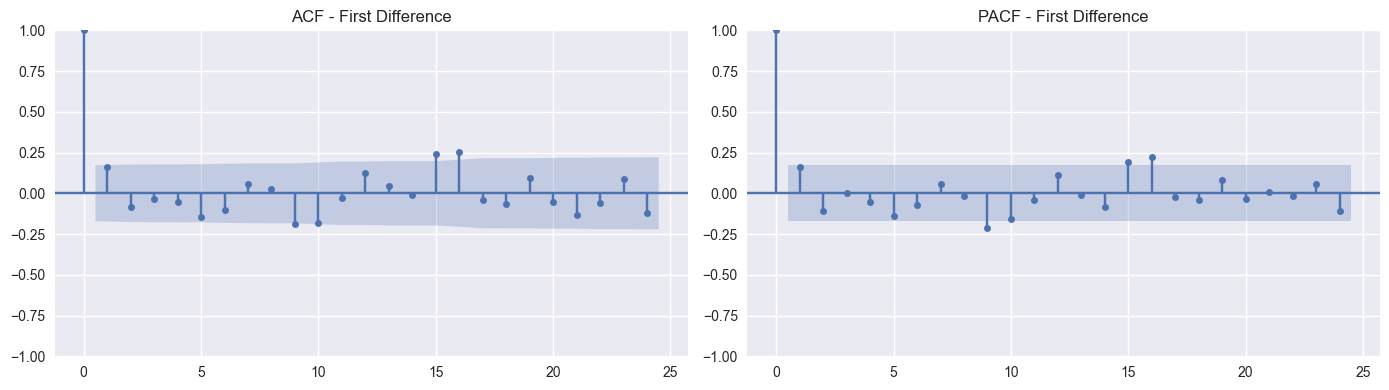

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(series['y_diff1'].dropna(), lags=24, ax=axes[0])
axes[0].set_title("ACF - First Difference")

plot_pacf(series['y_diff1'].dropna(), lags=24, ax=axes[1])
axes[1].set_title("PACF - First Difference")

plt.tight_layout()
plt.show()

From ACF, we can only see significant lags at 15,16 but these spikes are not model structure, they are noise. Hence we are gonna use MA (p) = 0

From PACF, the only spikes occur around lag 15–16, too late to represent autoregressive structure. AR (q) = 0

And as there is no seasonability, we can go with ARIMA (p,d,q) model, here it will be (0,1,0)

First lets split the data into training and testing (last 12 months will be used for testing)

In [82]:
n_test = 12
train = series.iloc[:-n_test]
test = series.iloc[-n_test:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 119
Test size: 12


In [83]:
order = (0, 1, 0)  # (p,d,q)

model = ARIMA(train['y'], order=order)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  119
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -418.965
Date:                Tue, 25 Nov 2025   AIC                            839.930
Time:                        11:47:17   BIC                            842.701
Sample:                    01-31-2015   HQIC                           841.055
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        71.0387      8.015      8.863      0.000      55.329      86.748
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.32   Pr

2024-12-31    236.261459
2025-01-31    236.261459
2025-02-28    236.261459
2025-03-31    236.261459
2025-04-30    236.261459
2025-05-31    236.261459
2025-06-30    236.261459
2025-07-31    236.261459
2025-08-31    236.261459
2025-09-30    236.261459
2025-10-31    236.261459
2025-11-30    236.261459
Freq: ME, Name: predicted_mean, dtype: float64


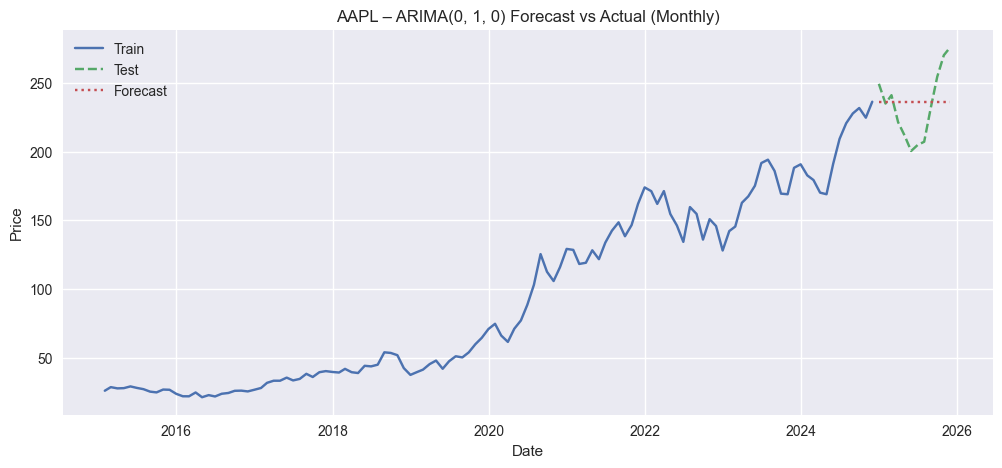

In [84]:
forecast = model_fit.forecast(steps=len(test))

print(forecast)

plt.plot(train.index, train['y'], label="Train")
plt.plot(test.index, test['y'], label="Test", linestyle="--")
plt.plot(test.index, forecast, label="Forecast", linestyle="dotted")
plt.title(f"{ticker} – ARIMA{order} Forecast vs Actual (Monthly)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


ARIMA(0,1,0) produced a constant forecast because stock prices typically follow a random walk. This means future prices are statistically unpredictable, and the best forecast is the last observed value.

We included this model as a baseline.

To obtain a smoother and more interpretable forecast, we additionally implemented ARIMA(1,1,1) and Prophet, which capture trend components better.

In [85]:
order2 = (1,1,1)

model2 = ARIMA(train['y'],order = order2)
model2_fit = model2.fit()

2024-12-31    236.261459
2025-01-31    236.261459
2025-02-28    236.261459
2025-03-31    236.261459
2025-04-30    236.261459
2025-05-31    236.261459
2025-06-30    236.261459
2025-07-31    236.261459
2025-08-31    236.261459
2025-09-30    236.261459
2025-10-31    236.261459
2025-11-30    236.261459
Freq: ME, Name: predicted_mean, dtype: float64


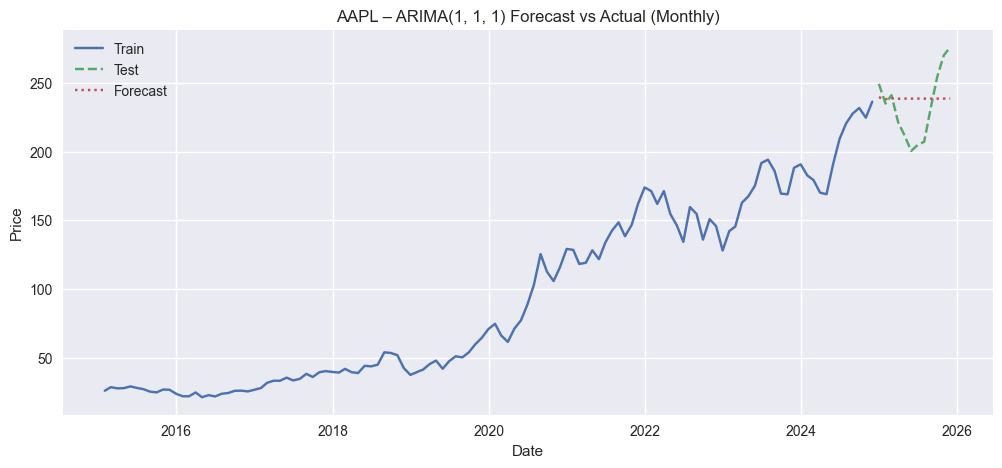

In [86]:
forecast2 = model2_fit.forecast(steps=len(test))

print(forecast)

plt.plot(train.index, train['y'], label="Train")
plt.plot(test.index, test['y'], label="Test", linestyle="--")
plt.plot(test.index, forecast2, label="Forecast", linestyle="dotted")
plt.title(f"{ticker} – ARIMA{order2} Forecast vs Actual (Monthly)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [87]:
rmse = np.sqrt(mean_squared_error(test['y'], forecast))
mae = mean_absolute_error(test['y'], forecast)

print(f"ARIMA(1,1,1) RMSE: {rmse:.4f}")
print(f"ARIMA(1,1,1) MAE : {mae:.4f}")

ARIMA(1,1,1) RMSE: 24.5071
ARIMA(1,1,1) MAE : 20.9117


Now, lets try the Prophet Model

Prophet model needs the columns to be named exactly 'ds' and 'y' and we can not have the extra differencial column in here.

In [88]:
monthly = series[['y']].copy()

prophet_df = monthly.reset_index()

prophet_df.columns = ['ds', 'y']

prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')

prophet_df.head(), prophet_df.dtypes

(          ds          y
 0 2015-01-31  25.973394
 1 2015-02-28  28.590902
 2 2015-03-31  27.693958
 3 2015-04-30  27.854210
 4 2015-05-31  29.117092,
 ds    datetime64[ns]
 y            float64
 dtype: object)

Prophet handles trends, seasonality, holidays, all be default. No need of ACF PACF analysis

In [89]:
from prophet import Prophet

proph = Prophet()          
proph.fit(prophet_df)


11:47:17 - cmdstanpy - INFO - Chain [1] start processing
11:47:17 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
future = proph.make_future_dataframe(periods=12, freq='M')   
forecast = proph.predict(future)

/opt/miniconda3/envs/tsa/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [91]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
138,2026-07-31,266.907436,248.914907,285.079601
139,2026-08-31,271.823663,253.503864,288.633645
140,2026-09-30,270.185717,253.075311,287.316858
141,2026-10-31,275.549221,256.413196,293.794290
142,2026-11-30,280.426214,262.084788,299.194329


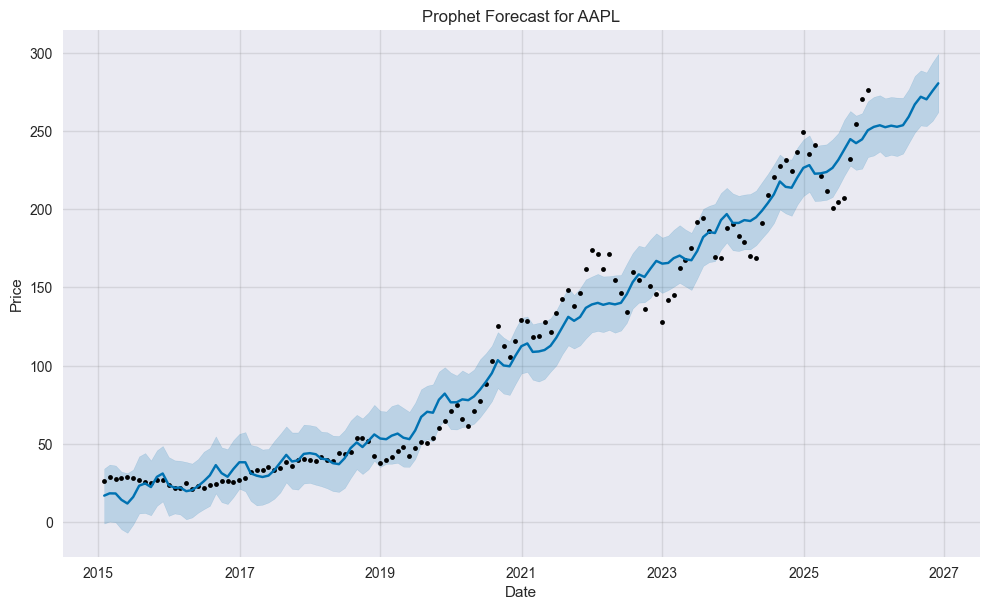

In [92]:
fig1 = proph.plot(forecast)
plt.title("Prophet Forecast for AAPL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


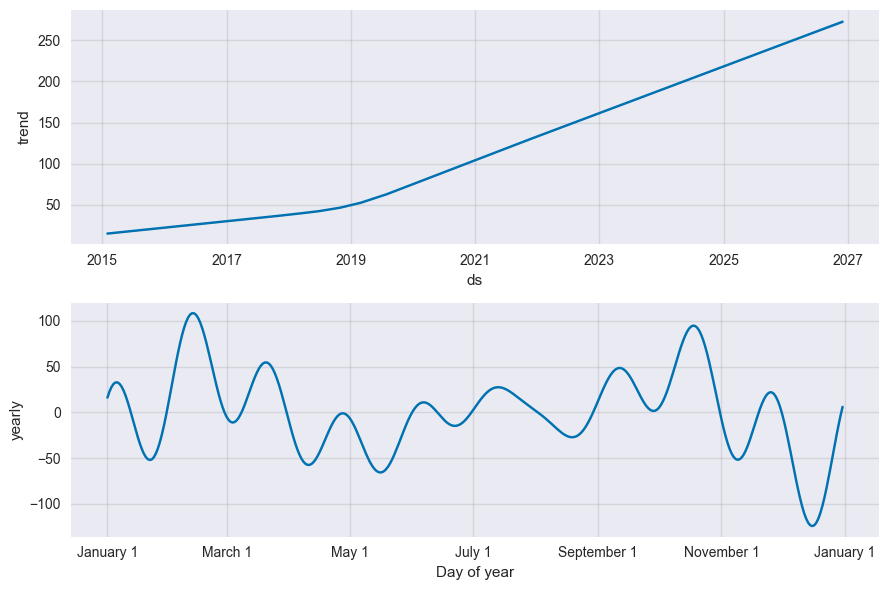

In [93]:
fig2 = proph.plot_components(forecast)
plt.show()

We generated unseen data with our current prophet model, now lets try in on our train test splitted data.

In [94]:
train_prophet = prophet_df.iloc[:-12]
test_prophet = prophet_df.iloc[-12:]


In [95]:
m = Prophet()
m.fit(train_prophet)

11:47:17 - cmdstanpy - INFO - Chain [1] start processing
11:47:17 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

/opt/miniconda3/envs/tsa/lib/python3.11/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


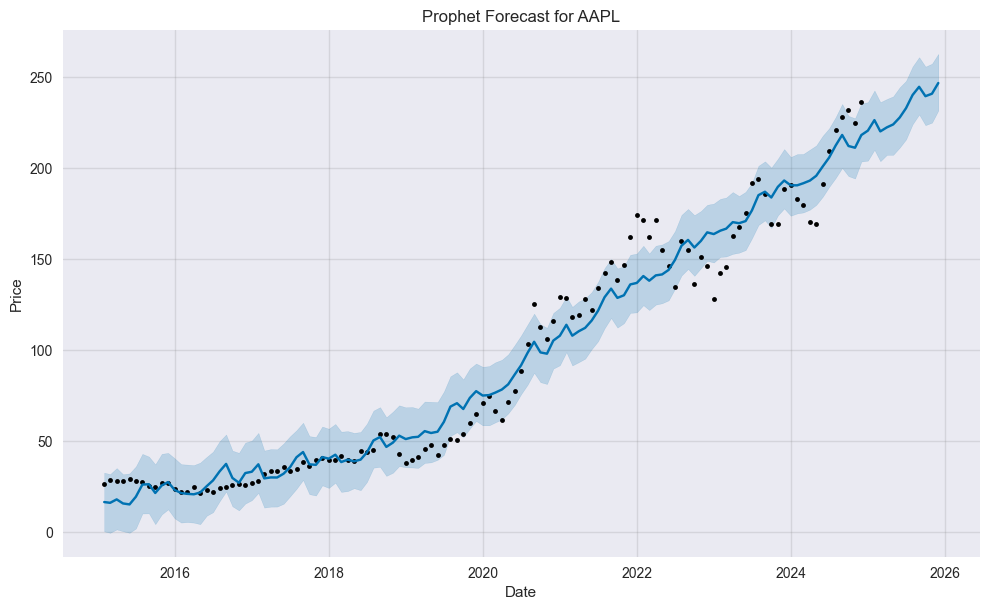

In [97]:
fig1 = m.plot(forecast)
plt.title("Prophet Forecast for AAPL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [98]:
pred = forecast.set_index('ds').loc[test_prophet['ds'], 'yhat']

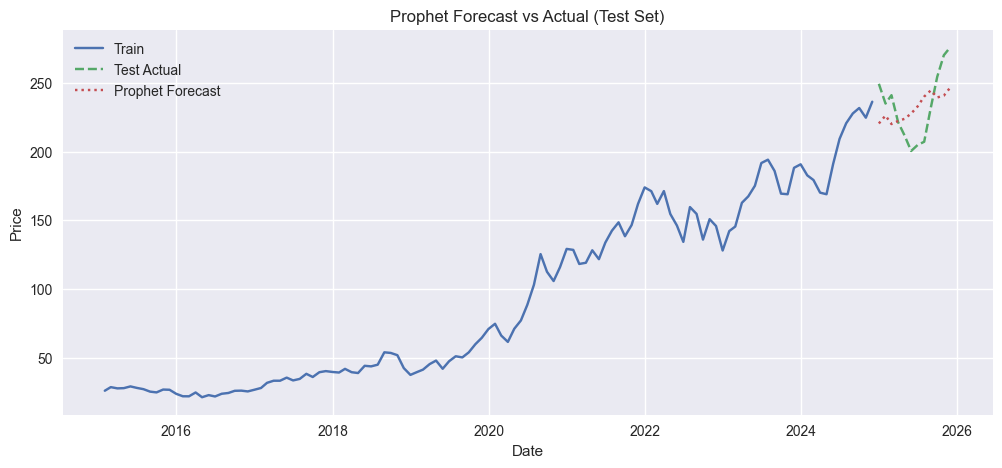

In [100]:
plt.figure(figsize=(12,5))
plt.plot(train_prophet['ds'], train_prophet['y'], label="Train")
plt.plot(test_prophet['ds'], test_prophet['y'], label="Test Actual", linestyle="--")
plt.plot(test_prophet['ds'], pred, label="Prophet Forecast", linestyle="dotted")
plt.title("Prophet Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [99]:
rmse = np.sqrt(mean_squared_error(test_prophet['y'], pred))
mae = mean_absolute_error(test_prophet['y'], pred)

print("Prophet RMSE:", rmse)
print("Prophet MAE:", mae)

Prophet RMSE: 22.752717031432333
Prophet MAE: 20.49722262226877
